# ¿Qué tan buenos somos para reconocer personas?

<img src="https://i.imgur.com/ECpBSfn.jpg" width="50%" />

<center>¿Jack Nicholson o Leonardo Dicaprio?</center>

<img src="http://1.bp.blogspot.com/_BQ05SdY_Qk0/SmoUY1TVaeI/AAAAAAAAAUE/NwiqQgpb_Dg/s400/Fabio+Posca+-+Bob+Pati%C3%B1o.jpg" width="50%" />

<div>

<img src="https://i.imgur.com/0ppqBFz.jpg" width="25%" />
<img src="https://lh6.googleusercontent.com/-60b0uUWJlhA/AAAAAAAAAAI/AAAAAAAAt4E/BHc54O2XIqs/photo.jpg" width="25%" />

</div>

<center>¿Fisa o guerrero medieval?</center>


# Imports y configs

In [1]:
# imports de libs que usamos para leer y procesar datos en masa
import os

import numpy as np
import pandas as pd

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning: separar conjuntos de datos, evaluar exactitud, etc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# libs que usamos para construir y entrenar redes neuronales
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [2]:
# algunas configuraciones generales respecto a las imagenes
PICTURE_SIZE = 64
CHANNELS = 'rgb'

INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend(['%s%i' % (color, i)
                          for i in range(PICTURE_SIZE ** 2)])

Datos
=====

Para que esto funcione, deben bajar el archivo ``data_64x64.pkl`` desde [este link](https://drive.google.com/drive/folders/0B5cCDhynqkqDczZDd3JTSENFcDg?usp=sharing) y ubicarlo en el mismo directorio que el notebook (en el link los archivos están comprimidos, así que van a tener que extraerlos después de bajarlos).

Cada fila es una imagen. Cada imagen tiene muchos pixeles. Y cada pixel tiene 3 valores: cuánto de rojo, cuánto de verde y cuánto de azul (estos son "canales" de color).

Eso quiere decir que si la imagen tiene 64 x 64 pixeles, y cada pixel tiene 3 valores, entonces tenemos 64 x 64 x 3 = 12.288 columnas.

Luego tenemos 3 columnas más que no son pixeles: 

- 'person': indica que persona está en la foto, o dicho técnicamente, la etiqueta para ese caso (ariel, fisa, gabi o mariano)
- 'file': el nombre de la imagen original (para uso interno nuestro)
- 'place': el lugar donde fue tomado el video (nos sirve para separar sets de imágenes)

En el link donde está el dataset también les dejamos imágenes en menor resolución (24x24 y 32x32), por si les demora demasiado y quieren intentar con sets más livianos. Si van a usar otro dataset y no el de 64x64, recuerden actualizar la setting ``PICTURE_SIZE``.

In [3]:
print('reading data...')
data = pd.read_pickle('./data_{}x{}.pkl'.format(PICTURE_SIZE, PICTURE_SIZE))
data.shape

reading data...


(4920, 12291)

In [4]:
data.sample(5)

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b4089,b4090,b4091,b4092,b4093,b4094,b4095,file,person,place
3426,176,177,180,181,182,183,184,186,186,186,...,184,173,165,189,231,227,228,gabi_pared_mp4_284.jpg,gabi,pared
2407,182,182,183,183,183,183,183,183,183,184,...,28,28,27,27,30,33,27,fisa_pared_mp4_435.jpg,fisa,pared
2188,190,190,188,188,190,192,190,188,189,191,...,30,33,37,40,35,38,54,fisa_pared_mp4_216.jpg,fisa,pared
2554,120,119,122,121,118,117,117,116,114,112,...,50,55,53,52,51,53,57,gabi_aula_mp4_033.jpg,gabi,aula
3668,190,192,193,194,194,195,195,196,196,195,...,24,21,22,28,31,30,28,gabi_pared_mp4_526.jpg,gabi,pared


Y consultamos además qué etiquetas hay en general:

In [5]:
PERSONS = list(data.person.unique())
PERSONS

['ariel', 'fisa', 'gabi', 'mariano']

Esta función nos permite pasarle un conjunto de imagenes (filas de la tabla), y nos las dibuja. También admite usar varias columnas de la tabla como título para cada imagen.

In [6]:
def show_images(samples, title='file'):
    for index, sample in samples.iterrows():
        if title is not None:
            if isinstance(title, str):
                title = [title, ]
            title_text = ', '.join(str(sample[title_field]) for title_field in title)
            plt.title(title_text)

        sample_as_grid = sample[INPUT_COLUMNS].values.reshape(len(CHANNELS), PICTURE_SIZE, PICTURE_SIZE).astype(np.float)
        sample_as_grid = np.transpose(sample_as_grid, (1, 2, 0)) / 255
        
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')

        plt.show()

Mostramos algunas imágenes de ejemplo al azar. Pueden ustedes distinguir lo que hay en cada imagen? (si ejecutan esta celda muchas veces, van a ir viendo imágenes diferentes).

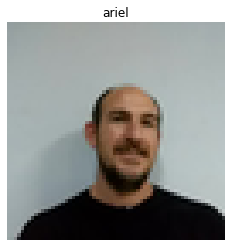

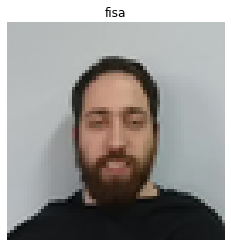

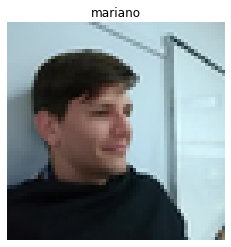

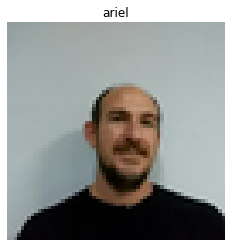

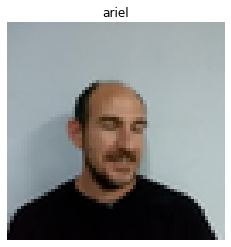

In [7]:
show_images(data.sample(5), 'person')

Y finalmente, separamos los datos en dos conjuntos, vamos a utilizar uno para entrenar la red y el otro para testearla (y de esa forma asegurarnos de que no estamos sobreentrenando, evaluar cómo se va a comportar con casos que no usó para entrenar, etc).
Para hacer esto nos vamos a valer del lugar dónde fue sacada la foto, es decir, vamos a construir nuestro conjunto de test a partir de las fotos que tienen como fondo la cortina.

#################### train labels ####################


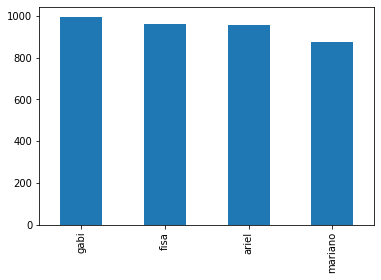

#################### test labels ####################


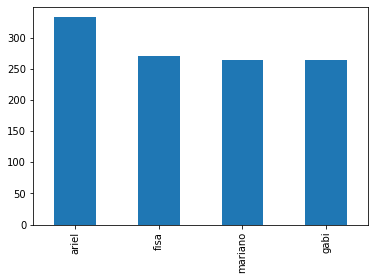

In [8]:
train = data[data.place != 'cortina'].copy()
test = data[data.place == 'cortina'].copy()

sets = (
    ('train', train),
    ('test', test),
)

for set_name, set_data in sets:
    print('#' * 20, set_name, 'labels', '#' * 20)
    set_data.person.value_counts().plot.bar()
    plt.show()

Red neuronal
============

Estas funciones nos van a ser útiles para no repetir código cada vez que queramos obtener las columnas de entrada y las salidas, en el formato de arrays que la red neuronal espera.

In [9]:
def extract_inputs(dataset):
    """
    Extrae del conjunto de datos original solo las 
    columnas que se deben utilizar como entrada. 
    """
    # estandarización rápida y simple: dividir todo por 255 :)

    # si queremos usar MLP básico:
    #return dataset[INPUT_COLUMNS].values / 255
    
    # si queremos usar convolucionales:
    return dataset[INPUT_COLUMNS].values.reshape(len(dataset), PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)) / 255


def extract_outputs(dataset):
    """
    Extrae del conjunto de datos original solo la 
    columna que se debe utilizar como salida y retorna
    tantas columnas como etiquetas distintas existan.
    Por ejemplo, podríamos pensar que las columnas resultantes
    serían: es_fisa, es_gabi, es_mariano.
    """
    is_person_columns = [(dataset.person == person).values for person in PERSONS]
    return np.array(is_person_columns).T

Y aquí es donde creamos y entrenamos el modelo:

In [10]:
model = Sequential([
    # si queremos usar MLP básico:
    #Dense(10, activation='tanh', input_shape=(len(INPUT_COLUMNS), )),
    #Dropout(0.2),
    # /fin MLP básico
    
    # si queremos usar convolucionales:
    Convolution2D(8, (4, 4), activation='relu', input_shape=(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)),),
    Convolution2D(8, (4, 4), activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(0.2),
    Flatten(),
    # /fin convolucionales
    
    Dense(10, activation='tanh'),
    Dropout(0.2),
    Dense(10, activation='tanh'),
    Dropout(0.2),

    Dense(len(PERSONS), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [11]:
history = model.fit(
    extract_inputs(train), 
    extract_outputs(train), 
    epochs=5,
    batch_size=128,
    validation_data=(
        extract_inputs(test),
        extract_outputs(test),
    )
)

Epoch 1/5
30/30 [==============================] - 6s 192ms/step - loss: 1.3390 - accuracy: 0.3315 - val_loss: 1.1068 - val_accuracy: 0.6490
Epoch 2/5
30/30 [==============================] - 10s 325ms/step - loss: 0.9442 - accuracy: 0.6748 - val_loss: 0.7807 - val_accuracy: 0.7610
Epoch 3/5
30/30 [==============================] - 8s 252ms/step - loss: 0.6535 - accuracy: 0.8204 - val_loss: 0.6760 - val_accuracy: 0.7443
Epoch 4/5
30/30 [==============================] - 9s 306ms/step - loss: 0.4849 - accuracy: 0.8965 - val_loss: 0.7494 - val_accuracy: 0.6270
Epoch 5/5
30/30 [==============================] - 8s 273ms/step - loss: 0.3797 - accuracy: 0.9316 - val_loss: 0.6341 - val_accuracy: 0.7081


Una vez entrenada, se puede evaluar la performance de la red neuronal utilizando los dos conjuntos, con este fragmento de código.

Esta función nos va a ser útil para agrupar las predicciones y poder comparar.

In [12]:
def add_predictions(dataset):
    """
    Agregamos una columna 'prediction' con el label de la persona predicha.
    Otra columna 'prediction_confidence' con el valor que la red devolvió 
    para esa persona.
    Y una última columna 'correct', que determina si la predicción fue o no
    correcta.
    """
    predictions = model.predict(extract_inputs(dataset))

    for person_number, person in enumerate(PERSONS):
        dataset[person] = predictions[:, person_number]
    
    dataset['prediction'] = dataset[PERSONS].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[PERSONS].max(axis=1)
    dataset['correct'] = dataset.prediction == dataset.person

######################### train #########################
accuracy 0.9994717379820391


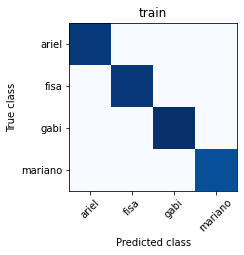

######################### test #########################
accuracy 0.7081128747795414


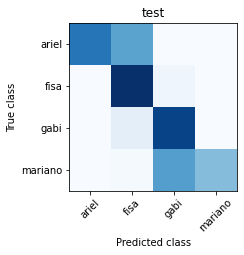

In [13]:
for set_name, set_data in sets:
    add_predictions(set_data)
    
    print('#' * 25, set_name, '#' * 25)
    print('accuracy', accuracy_score(set_data.person, set_data.prediction))

    # plot confussion matrix
        
    plt.figure(figsize=(3,4))
        
    plt.xticks([0, 1, 2, 3], PERSONS, rotation=45)
    plt.yticks([0, 1, 2, 3], PERSONS)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.person, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

Y además siempre es útil analizar el comportamiento de las curvas de aprendizaje.

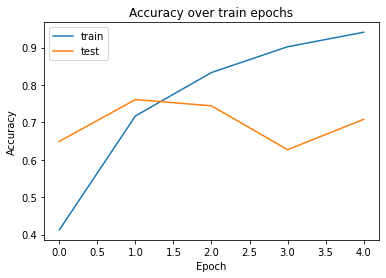

In [14]:
# plot accuracy over training epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Finalmente, podemos mostrar algunos ejemplos del conjunto de test para evaluar cómo le fue (las predicciones fueron agregadas en el paso anterior, al llamar a ``add_predictions``).

El título en cada imagen indica el nombre de la persona en la foto seguido de la predicción que hizo la red.

Mostramos primero algunos que hayan sido bien clasificados, y luego otros que hayan sido mal clasificados.

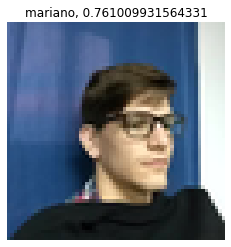

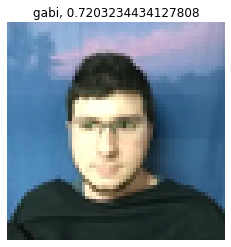

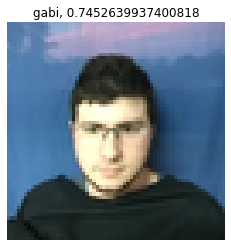

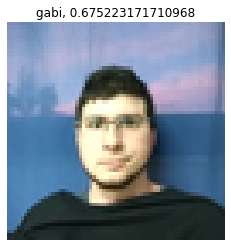

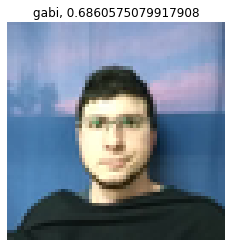

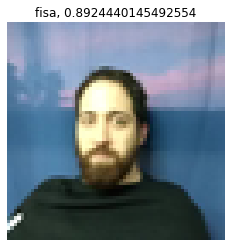

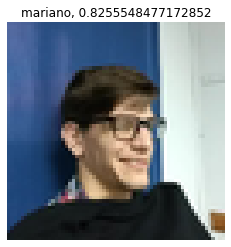

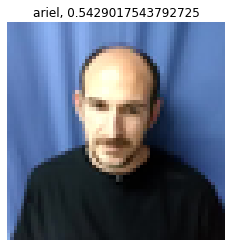

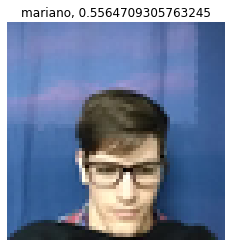

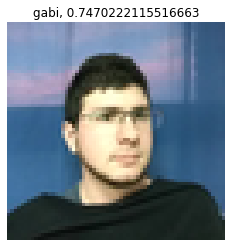

In [15]:
show_images(test[test.person == test.prediction].sample(10), title=['prediction', 'prediction_confidence'])

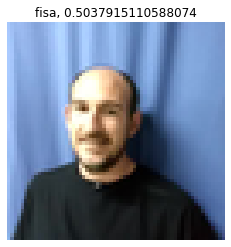

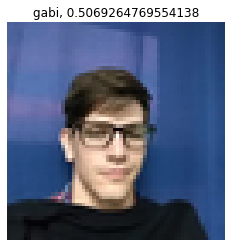

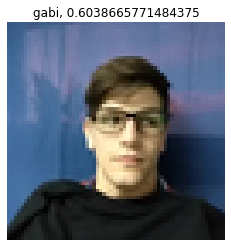

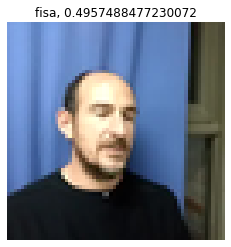

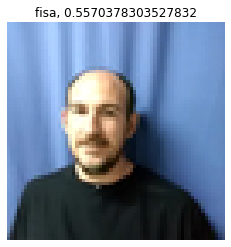

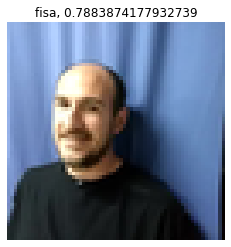

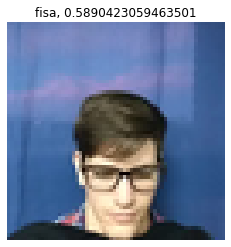

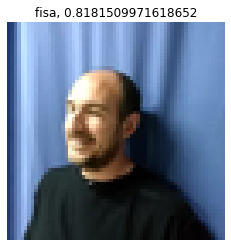

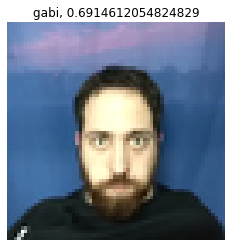

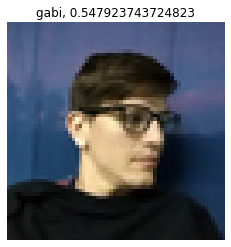

In [16]:
show_images(test[test.person != test.prediction].sample(10), title=['prediction', 'prediction_confidence'])